In [1]:
from markets.dynamic_market import Segment, GeoMarket, Stock
from markets.stocks_model import rnd_sentiments

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
sns.set_style('darkgrid')
sns.set(rc={'figure.figsize': (12,4)})

In [5]:
import numpy as np
# Repeatable random: Always set a seed!
np.random.seed(17)

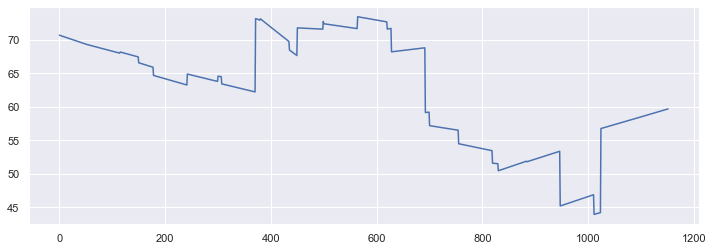

In [6]:
sentiments = rnd_sentiments()       # quarterly impacted stock sentiments
beta_geo = .15       # exposure (beta) to the US market
beta_it = .25       # exposure (beta) to the IT sector
e_cagr = 1e-4
max_effect = 3.0
psi0 = 70
it = Segment('Information Technology', {0: (.0, -.002)})
us = GeoMarket('US',  # A name
               {0: (.1, -0.0005),  # Market sentiment over time, starting slightly bullish
                150: (-.1, -0.001),
                300: (-.13, 0),  # Not too bad yet
                380: (-.1, -0.005),  # A period of hope
                450: (.15, 0.003),
                500: (.25, 0),  # And more hope
                620: (.1, 0.004),
                700: (.1, 0.001),
                830: (.05, 0.007)
                })

ticker = 'AAPL'
stock = Stock(name=ticker, e_cagr=e_cagr, max_effect=max_effect, psi0=psi0,
              segments={it: beta_it}, markets={us: beta_geo},
              sentiments=sentiments, noise=.4)

stocks = {ticker: stock}

plt.plot([stock.psi(t) for t in range(1152)]);

### The old Model
#### Michael is trading a single stock: AAPL (Ok ok, in reality, he wouldn't ever...;-)

In [7]:
import markets.dynamic_market as old
portfolio = {stock.name: 10000}
michael = old.MomentumInvestor(
    name="Michael Burry", 
    wealth=1000000, 
    portfolio=portfolio)

market = old.Market(stocks=list(stocks.values()), bid_ask=0.2)
market.open()

print("Michael's position in %s before acting: %s" % (ticker, michael.portfolio[ticker]))
print("Current prices (bid, ask): %s, %s" % market.price_for(ticker))

michael.act_on(market, ticker)
print()

print("Michael's position in %s after  acting: %s" % (ticker, michael.portfolio[ticker]))
print("Current prices (bid, ask): %s, %s" % market.price_for(ticker))

Michael's position in AAPL before acting: 10000
Current prices (bid, ask): 70.885, 70.485

Michael's position in AAPL after  acting: 9990
Current prices (bid, ask): 70.685, 70.285


---
## New Market Model

In [9]:
import ray
ray.init()

2020-09-27 22:15:59,005	INFO resource_spec.py:223 -- Starting Ray with 32.91 GiB memory available for workers and up to 16.46 GiB for objects. You can adjust these settings with ray.init(memory=<bytes>, object_store_memory=<bytes>).
2020-09-27 22:15:59,579	INFO services.py:1191 -- View the Ray dashboard at localhost:8265


{'node_ip_address': '192.168.1.126',
 'raylet_ip_address': '192.168.1.126',
 'redis_address': '192.168.1.126:51661',
 'object_store_address': '/tmp/ray/session_2020-09-27_22-15-58_996687_758/sockets/plasma_store',
 'raylet_socket_name': '/tmp/ray/session_2020-09-27_22-15-58_996687_758/sockets/raylet',
 'webui_url': 'localhost:8265',
 'session_dir': '/tmp/ray/session_2020-09-27_22-15-58_996687_758'}

In [10]:
from markets.realistic import *
sc = RayMarketScenario()
initial_prices = {
    'TSMC': 100,
    'NVDA': 200,
    'AAPL': 140,
    'SNOW': 400,
    'GE': '20'
}
mm = MarketMaker(initial_prices)

warren = MomentumInvestor(name='Warren Buffet', portfolio={'TSMC': 5000, 'CASH': 200_000},
                          market_maker=mm)

In [11]:
sc.register_investors(warren)
sc.investors[0]

Actor(RayInvestor, 45b95b1c0100)

In [12]:
sc.identify_investors()

['Warren Buffet@192.168.1.126']

In [16]:
ray.shutdown()


---
## Matching Orders in practise

In [16]:
import numpy as np
import seaborn as sns
import datetime as dt
import pandas as pd

In [17]:
from markets.realistic import *

In [19]:
expiry = dt.datetime.now() + dt.timedelta(hours=1)

In [20]:
symbol = 'TSMC'

In [21]:
buyer = TriangularOrderGenerator(split=.1, client_id=uuid.uuid4(), expiry=expiry)
seller = TriangularOrderGenerator(split=.1, client_id=uuid.uuid4(), expiry=expiry)

---
Buy orders

In [22]:
buy_orders = buyer.create_orders_df(symbol, 340, .004, 1000, OrderType.BID)
sell_orders = seller.create_orders_df(symbol, 341, .006, 1200, OrderType.ASK)
buy_orders.head()

,price,amount,other_party,symbol,expiry,order_type
0,339.42,153.932988,60c04af1-77fb-4c17-b922-c1537737799e,TSMC,2020-09-27 14:41:54.671737,OrderType.BID
1,339.53,141.105239,60c04af1-77fb-4c17-b922-c1537737799e,TSMC,2020-09-27 14:41:54.671737,OrderType.BID
2,339.63,128.277490,60c04af1-77fb-4c17-b922-c1537737799e,TSMC,2020-09-27 14:41:54.671737,OrderType.BID
3,339.74,115.449741,60c04af1-77fb-4c17-b922-c1537737799e,TSMC,2020-09-27 14:41:54.671737,OrderType.BID
4,339.84,102.621992,60c04af1-77fb-4c17-b922-c1537737799e,TSMC,2020-09-27 14:41:54.671737,OrderType.BID


---
Sell orders

In [13]:
sell_orders = seller.create_orders_df(symbol, 341, .006, 1200, OrderType.ASK)
sell_orders.head()

,price,amount,other_party,symbol,expiry,order_type
0,339.98,0.000000,b8a96dec-56d4-404d-9b7f-1f2c3af5d26e,TSMC,2020-09-15 20:15:12.284961,OrderType.ASK
1,340.08,6.310110,b8a96dec-56d4-404d-9b7f-1f2c3af5d26e,TSMC,2020-09-15 20:15:12.284961,OrderType.ASK
2,340.18,12.620221,b8a96dec-56d4-404d-9b7f-1f2c3af5d26e,TSMC,2020-09-15 20:15:12.284961,OrderType.ASK
3,340.28,18.930331,b8a96dec-56d4-404d-9b7f-1f2c3af5d26e,TSMC,2020-09-15 20:15:12.284961,OrderType.ASK
4,340.39,25.240441,b8a96dec-56d4-404d-9b7f-1f2c3af5d26e,TSMC,2020-09-15 20:15:12.284961,OrderType.ASK


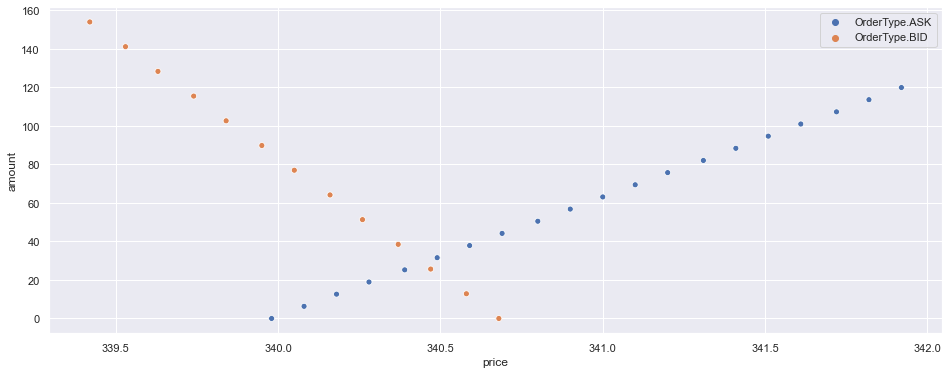

In [23]:
plt.figure(figsize=(16, 6))
data = pd.concat([sell_orders, buy_orders])
sns.scatterplot(data=data, x='price', y='amount', hue=data['order_type'].to_list());

In [30]:
mm = MarketMaker({symbol: 200})
mm.register_participant(buyer.client_id, {symbol: 1000, 'CASH': 200_000})
mm.register_participant(seller.client_id, {symbol: 2000, 'CASH': 100_000})
mm.participants

{UUID('9410319c-e14a-40f6-8d96-39b77de7323c'): {'TSMC': 1000, 'CASH': 200000},
 UUID('28fccc22-8f59-4d8e-b939-57dfd85b5b7b'): {'TSMC': 2000, 'CASH': 100000}}

In [16]:
i=5; data.iloc[i:i+1]

,price,amount,other_party,symbol,expiry,order_type
5,340.49,31.550552,1a0e143b-f718-4bf9-88fd-d3055b5cfac9,TSMC,2020-09-14 12:20:04.940894,OrderType.ASK


In [17]:
i=29; data.iloc[i:i+1]

,price,amount,other_party,symbol,expiry,order_type
9,340.37,38.483247,005462ae-2475-4ee9-97ae-a5440dd0b1f8,TSMC,2020-09-14 12:20:04.940894,OrderType.BID


In [25]:
sell_orders = buyer.create_orders_list(symbol, 341, .006, 1200, OrderType.ASK)
sell_orders[:3]

[Order(other_party=UUID('ccd5f3d1-75aa-4cf8-839f-7b9a829f4cef'), order_type=<OrderType.ASK: 'ask'>, symbol='TSMC', amount=0.0, price=339.98, expiry=Timestamp('2020-09-14 12:20:04.940894')),
 Order(other_party=UUID('ccd5f3d1-75aa-4cf8-839f-7b9a829f4cef'), order_type=<OrderType.ASK: 'ask'>, symbol='TSMC', amount=6.310110374347303, price=340.08, expiry=Timestamp('2020-09-14 12:20:04.940894')),
 Order(other_party=UUID('ccd5f3d1-75aa-4cf8-839f-7b9a829f4cef'), order_type=<OrderType.ASK: 'ask'>, symbol='TSMC', amount=12.620220748694607, price=340.18, expiry=Timestamp('2020-09-14 12:20:04.940894'))]

In [27]:
orders = sell_orders[5:6]
orders

[Order(other_party=UUID('ccd5f3d1-75aa-4cf8-839f-7b9a829f4cef'), order_type=<OrderType.ASK: 'ask'>, symbol='TSMC', amount=31.550551871736502, price=340.49, expiry=Timestamp('2020-09-14 12:20:04.940894'))]

In [19]:
mm.submit_orders(symbol, sell_orders)

In [20]:
mm.orders

{}

In [34]:
from collections import OrderedDict
reg = OrderedDict()

In [37]:
a = [1,2,2]
del a[0]
a

[2, 2]

---

# Market Dynamics: Bid Order Matching

## Theory

In [8]:
# 10 cents slices
split = .1

In [9]:
# ask
N_a = 100
p_a = 270
V_a = N_S * p_S
tau_a = .2
p_a_lower, p_a_upper = p_a * ( 1 - .5 * tau_a), p_a * (1 + .5 * tau_a)
nu_a = int (tau_a * p_a / split )
print(nu_a, p_a_lower, p_a_upper)

NameError: name 'N_S' is not defined

In [140]:
# bid
N_b = 50
p_b = 230
V_b = N_b * p_b
tau_b = .25
h_b = p_b * (1 + .5 * tau_b)

p_b_lower, p_b_upper = p_b * ( 1 - .5 * tau_b), p_b * (1 + .5 * tau_b)
nu_b = int (tau_b * p_b / split )
print(nu_b, p_b_lower, p_b_upper)

575 201.25 258.75


### Trianguar bid distribution
Actual bid order price $p_b$, number of shares $N_b$, tolerance width from the order price $\tau_b$.

$
p_b = 230, N_b = 50, \tau_b = .25
$

The range of bid prices
$
\nu_b = \tau_b \cdot p_b
$

$
p_b^< = p_b \cdot ( 1 - \frac{1}{2} \tau_b) 
$

$
p_b^> = p_b \cdot ( 1 + \frac{1}{2} \tau_b) 
$

$
V_b = \sum_{i=0}^{\nu_b} n_i p_i
$

$
p_b(i) = p_b^< + \frac{p_b^> - p_b^<}{\nu_b} \cdot i
$

$
n_b^> = 0
$

We want $n_i$ to be linear in $i$

$
n_b(i) = \alpha_b(\nu) + \beta_b(\nu) \cdot i
$

$
V_b = \sum_{i=0}^{\nu_b} [\alpha(\nu) + \beta(\nu) \cdot i] \cdot [p_b^< + \frac{p_b^> - p_b^<}{\nu_b} \cdot i]
= A(\nu_b) \alpha_b + B(\nu_b) \beta_b
$

$
A_b(\nu) = \nu p_b^< + \frac{1}{2}(\nu+1)(p^b_> - p^b_<)
$

$
B_b(\nu) = \frac{\nu(\nu+1)}{2} p_b^< + (p_b^>-p_b^<)\frac{(\nu+1)(2\nu+1)}{6}
$

With those results, we can compute $\alpha$ and $\beta$:

$
\beta_b(\nu)=\frac{V_b}{B_b(\nu) - \nu A_b(\nu)}
$

$
\alpha_b(\nu)=\frac{\nu V_b}{\nu A_b(\nu) - B_b(\nu)}
$

In [15]:
a={'b': 0, 'a': 1}

In [17]:
del a['b']
a

{'a': 1}

In [18]:
a

{'a': 1}